In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

import multiprocessing

np.random.seed(114514)
xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has BBHx waveform


## General settings 

In [2]:
# the path of Taiji orbit 
orbit_CPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB")
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 
 
t_start = 10. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies.shape 

(21601,)

In [3]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies, dtype=bool)
for i in range(1, 40): 
    mask_idx = np.where(np.abs(data_frequencies - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 
data_frequencies = data_frequencies[mask]

# remove the frequencies below Taiji sensitive band 
mask = np.where(data_frequencies > 1e-5)[0]
data_frequencies = data_frequencies[mask]

data_frequencies.shape 

(21077,)

## Initialize CPU waveform generator 

In [4]:
# initialize  waveform generator, "primary" for IMRPhenomD 
WFG_CPU = WaveformGenerator(mode="primary")

# initialize response generator 
FDTDI_CPU = FDTDIResponseGenerator(orbit_class=orbit_CPU, waveform_generator=WFG_CPU)

# response settings 
response_kwargs_CPU = dict(
    modes=[(2,2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
)

## Initialize GPU waveform generator 

In [5]:
# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
)

## MBHB source parameters 

In [6]:
N_mbhb = 2500 # 5000 would be too many for the memory of 4080, therefor more mbhbs should be divided to batches and generated batch by batch
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(5.5, 6.5, N_mbhb)), # [Solar mass], for chirp_mass of 10^5 or smaller, a smaller dt is needed
    'mass_ratio': np.random.uniform(0.1, 1., N_mbhb), 
    'spin_1z': np.random.uniform(-0.99, 0.99, N_mbhb),
    'spin_2z': np.random.uniform(-0.99, 0.99, N_mbhb),
    'coalescence_time': np.random.uniform(t_start + DAY, t_end, N_mbhb) / DAY, # [day], start from t_start to ensure that at least 1-day waveform is within the data
    'coalescence_phase': np.random.uniform(0, TWOPI, N_mbhb),
    'luminosity_distance': np.power(10., np.random.uniform(4., 5., N_mbhb)), # [MPC]
    'inclination': np.arccos(np.random.uniform(-1., 1., N_mbhb)), # [rad]
    'longitude': np.random.uniform(0, TWOPI, N_mbhb), # [rad]
    'latitude': np.arcsin(np.random.uniform(-1., 1., N_mbhb)), # [rad]
    'psi': np.random.uniform(0, PI, N_mbhb) # [rad]
    }

## Calculate on CPU 

In [7]:
# convert to list used by CPU parallelization 
mbhb_parameter_list = []
for i in range(N_mbhb):
    tmp = dict()
    for k, v in mbhb_parameters.items():
        tmp[k] = v[i]
    mbhb_parameter_list.append(tmp)

def cpu_generator(param): 
    return FDTDI_CPU.Response(parameters=param, freqs=data_frequencies, **response_kwargs_CPU)

In [8]:
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    results_CPU = pool.map(cpu_generator, mbhb_parameter_list)
np.array(results_CPU).shape # (N_mbhb, N_channel, N_frequency)

/home/ps/.local/lib/python3.9/site-packages/WF4Py-1.1.0-py3.9.egg/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/home/ps/.local/lib/python3.9/site-packages/WF4Py-1.1.0-py3.9.egg/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/home/ps/.local/lib/python3.9/site-packages/WF4Py-1.1.0-py3.9.egg/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
/home/ps/.local/lib/python3.9/site-packages/WF4Py-1.1.0-py3.9.egg/WF4Py/waveform_models/

(2500, 3, 21077)

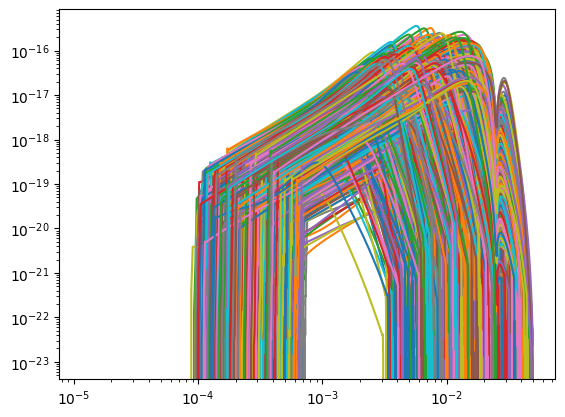

In [9]:
for i in range(N_mbhb):
    plt.loglog(data_frequencies, np.abs(results_CPU[i][0]))

## Calculate on GPU 

In [10]:
results_GPU = FDTDI_GPU.Response(mbhb_parameters, xp.array(data_frequencies), **response_kwargs_GPU)
results_GPU.shape 

(3, 2500, 21077)

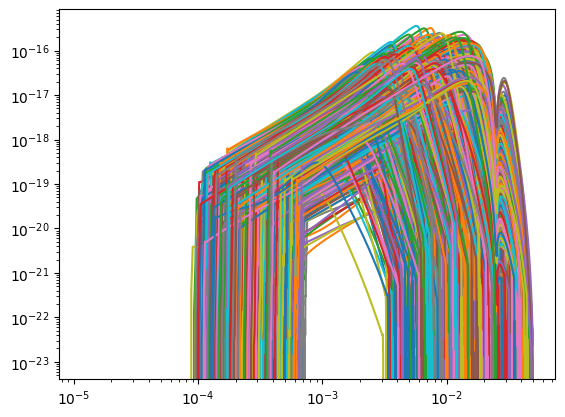

In [11]:
for i in range(N_mbhb):
    plt.loglog(data_frequencies, np.abs(results_CPU[i][0]))